# Hiver 2024 - Travail pratique 1

Leturger, Achille; Matricule: 11295037
Reau, Clement; Matricule: 11339062
Viau, Benjamin; Matricule: 11241571


Please, install requirements.txt to run the program

In [1]:
%matplotlib inline

# standard modules
import datetime as dt
import numpy as np
import pandas as pd
import pickle
import os
import warnings
import matplotlib.pyplot as matplt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.stats import norm
#from concurrent.futures import ProcessPoolExecutor

# Nous remercions et citons M. Dorion pour ses packages 
from dorion_francois.plot_utils import plt
import dorion_francois.toolkit as toolkit
import dorion_francois.black_merton_scholes as bms
from dorion_francois.toolkit import (assert_unique, 
        date2str, nancorr, printdf, subcalendar, tic, toc)
from dorion_francois.binomial_tree import option_price
# under development: this is bad practice ;)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import dorion_francois.option_metrics as om

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\1687620434.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Le code qui suit vous est fourni pour que vous voyiez comment le fichier `pkl` que vous chargerez a été généré.

## Question 1

Le code qui suit charge en mémoire, traite et décrit sommairement les options sur Apple telle que cotées le 24 octobre, 2008. Discuter.

In [2]:
# Load the data and define moneyness (MNY)
#surface = om.load_pickle('secid101594_20081024.pkl')
with open('secid101594_20081024.pkl','rb') as fh:
    surface = pickle.load(fh)
surface = surface[~np.isnan(surface.implied_vol_bms)]

# Note that MNY as defined as follows:
# surface['MNY'] = surface.strike / surface.implied_forward_price

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV,

,date,exdate,YTM,DTM,implied_forward_price,n_obs
0,2008-10-24,2008-11-22,0.079452,29.0,96.528704,34
1,2008-10-24,2008-12-20,0.156164,57.0,96.733148,30
2,2008-10-24,2009-01-17,0.232877,85.0,96.862495,51
3,2008-10-24,2009-04-18,0.482192,176.0,97.456509,46
4,2008-10-24,2010-01-16,1.230137,449.0,99.535349,37
5,2008-10-24,2011-01-22,2.246575,820.0,101.889256,12


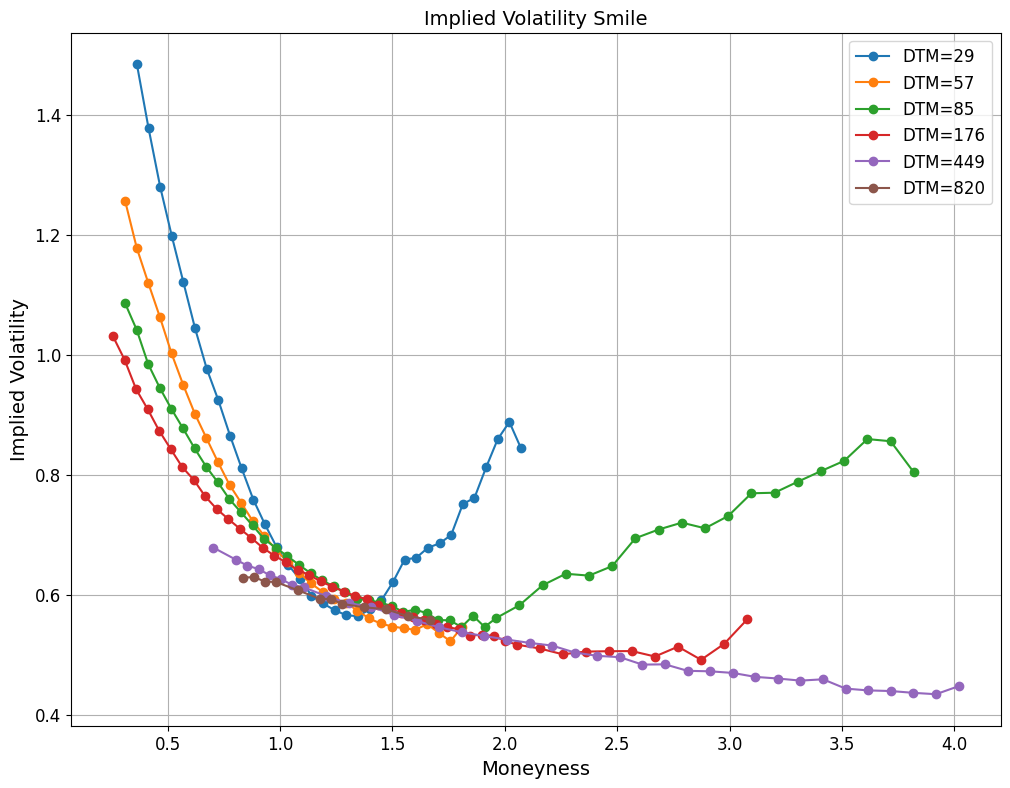

In [3]:
def summarize_surface(surface):
    summary = pd.DataFrame()
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    
    for no,smile in enumerate(om.Smile.iterator(surface)):
        smile._implied_forward_price = np.unique(smile.options.implied_forward_price)
        info = pd.DataFrame(smile.to_dict(),index=[no])  
        info['n_obs'] = smile.options.shape[0]
        summary = pd.concat((summary,info), axis=0)
        
        MNY = smile.options.MNY
        IV = smile.options.implied_vol_bms
        ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)

    # Graph formatting
    ax.legend()
    ax.set_title("Implied Volatility Smile")
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.grid()
    return summary

summarize_surface(surface)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV,

,date,exdate,YTM,DTM,implied_forward_price,n_obs
0,2008-10-24,2008-11-22,0.079452,29.0,96.528704,32
1,2008-10-24,2008-12-20,0.156164,57.0,96.733148,28
2,2008-10-24,2009-01-17,0.232877,85.0,96.862495,40
3,2008-10-24,2009-04-18,0.482192,176.0,97.456509,39
4,2008-10-24,2010-01-16,1.230137,449.0,99.535349,32
5,2008-10-24,2011-01-22,2.246575,820.0,101.889256,8


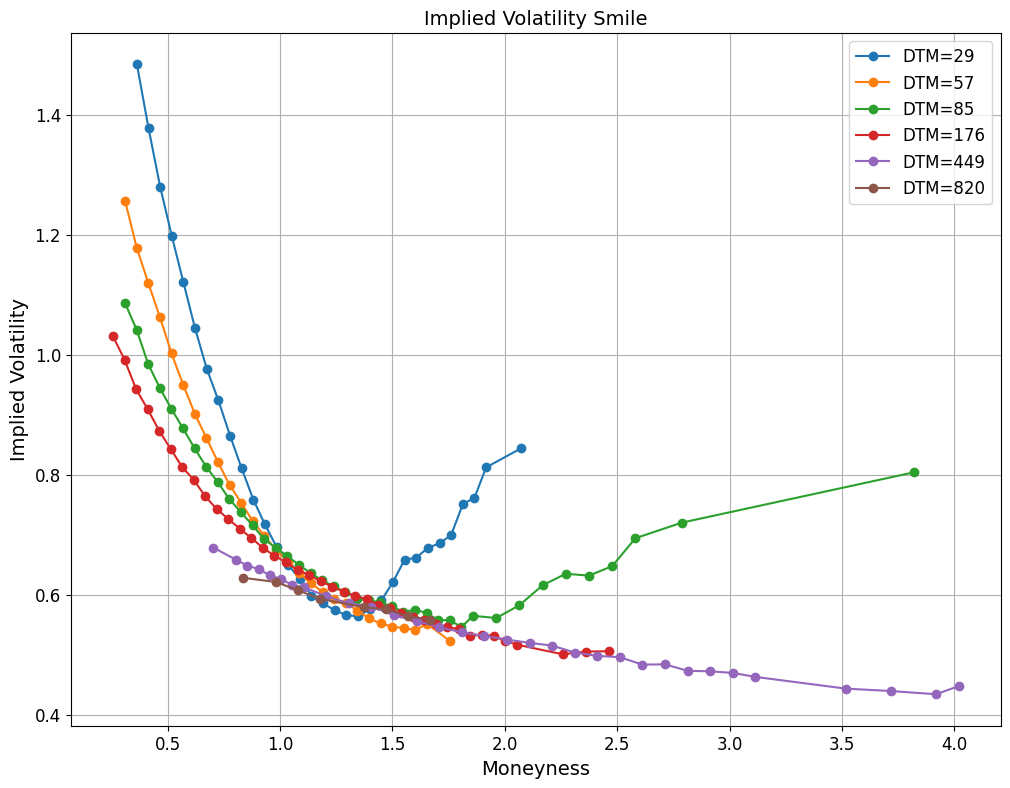

In [4]:
traded = surface[(surface.open_interest > 0) & (surface.volume > 0)]
summarize_surface(traded)

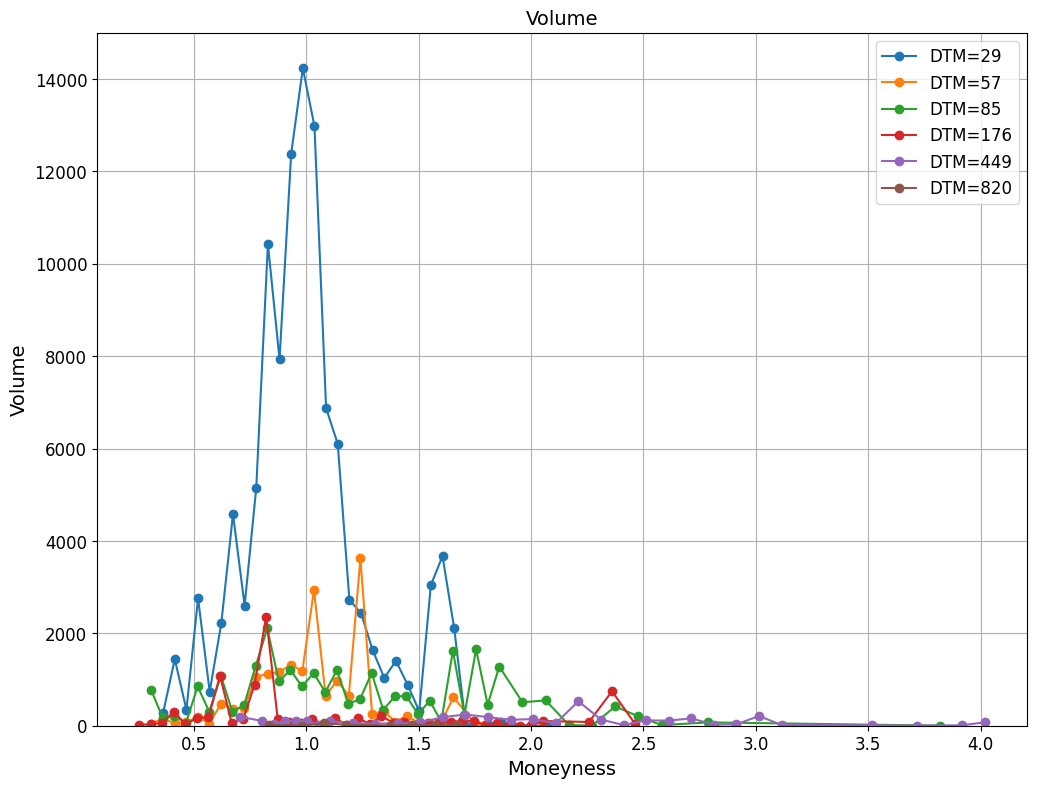

In [5]:
def plot_volume(surface, y_lim = 4000):
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    for no,smile in enumerate(om.Smile.iterator(surface)):
        MNY = smile.options.MNY
        VOL = smile.options.volume
        
        ax.plot(MNY, VOL, '-o', label='DTM=%d'%smile.DTM)
        ax.set_ylim([0, 15000])

    ax.legend()
    ax.set_title("Volume")
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Volume")
    ax.grid()
    
plot_volume(traded)

L'analyse des graphiques de volatilité implicite et de volume des différentes maturités et strike price d'options nous permets de mettre en lumière 3 phénomèmes : 

D'une part, le premier graphique démontre l'existence d'un "Volatility Skew" dans la volatilité implicite des options. Plus précisément, il y a présence d'un "volatility smirk". En effet, plus l'option est "Out-Of-The-Money", plus la volatilité implicite augmente relativement à la position "At-the-Money". Cependant, l'augmentation de la volatilité n'est pas symétrique. La volatilité implicite n'augmente pas autant pour les options "In-The-Money" que pour les options "Out-Of-The-Money". Cette réalité reflète la période économique durant laquelle les données sur les puts ont été collectées. En effet, l'inclinaison de la courbe de volatilité est influencée par les projections économiques des investisseurs. En période de crise, la probabilité d'événements négatifs est plus élevée que la possibilité d'événements positifs et donc contribue à augmenter la volatilité implicite d'un put OTM plus que d'un put ITM (Hasler and Jeanneret, 2022). L'inclinaison de la courbature reflète la situation économique de novembre 2008 ou la crise financière était à son paroxysme et le fait que la volatiité implicite est une mesure dite "forward looking".

D'autre part, nous pouvons remarquer la différence de volume de transactions entre les différentes maturités et strike price. En effet le volume de transactions pour des maturités plus courte est beaucoup plus important que pour de plus longues maturités. De plus, pour de courte maturité où le prix a relativement moins le temps de s'éloigner de son niveau actuel, le volume de transactions est beaucoup plus important pour les options proches du ATM.

Enfin, ce volume de transactions important ajouté à l'incertitude à très court terme de la période traitée augmente la demande de protection des investisseurs, ce qui explique que la volatilité implicite soit également plus importante à courte maturité, atteignant des variables extrêmes et normalement aberrantes (140% de implied volatility)

Cependant, l'option d'échéance 2 mois (en orange) semble défier les deux phénomènes observés. En effet, le volume est similaire à des maturités plus importantes, et le volatility smile semble moins marqué en comparaison aux autres maturités. Sans plus d'informations, nous pouvons donner comme hypothèse que la date d'échéance est moins attractive pour les investisseurs (période calme, pas de conférence ou de bilan financier de prévu...)

Hasler, M., & Jeanneret, A. (2023). A macrofinance model for option prices: A story of rare economic events. Management Science, 69(9), 5543–5559. https://doi.org/10.1287/mnsc.2022.4587 

## Question 2

En partant de `surface`, créez un DataFrame `sample` qui est restreint aux options de 3 mois ou moins de maturité, et qui sont au plus 30% hors de la monnaie. Invoquez `summarize_surface(sample)` et décrivez plus en détail ce que l'on peut inférez quant l'évolution anticipée à travers le temps (maturités) des ailes gauches et droites de la distribution risque neutre avec à l'aide de ces options.

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\3441039237.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample = pd.DataFrame(surface)[surface["DTM"] <= 90][surface["MNY"] <= 1.3]
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\957983959.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax.plot(MNY, IV, '-o', label='DTM=%d'%info.DTM)


,date,exdate,YTM,DTM,implied_forward_price,n_obs
0,2008-10-24,2008-11-22,0.079452,29.0,96.528704,19
1,2008-10-24,2008-12-20,0.156164,57.0,96.733148,20
2,2008-10-24,2009-01-17,0.232877,85.0,96.862495,20


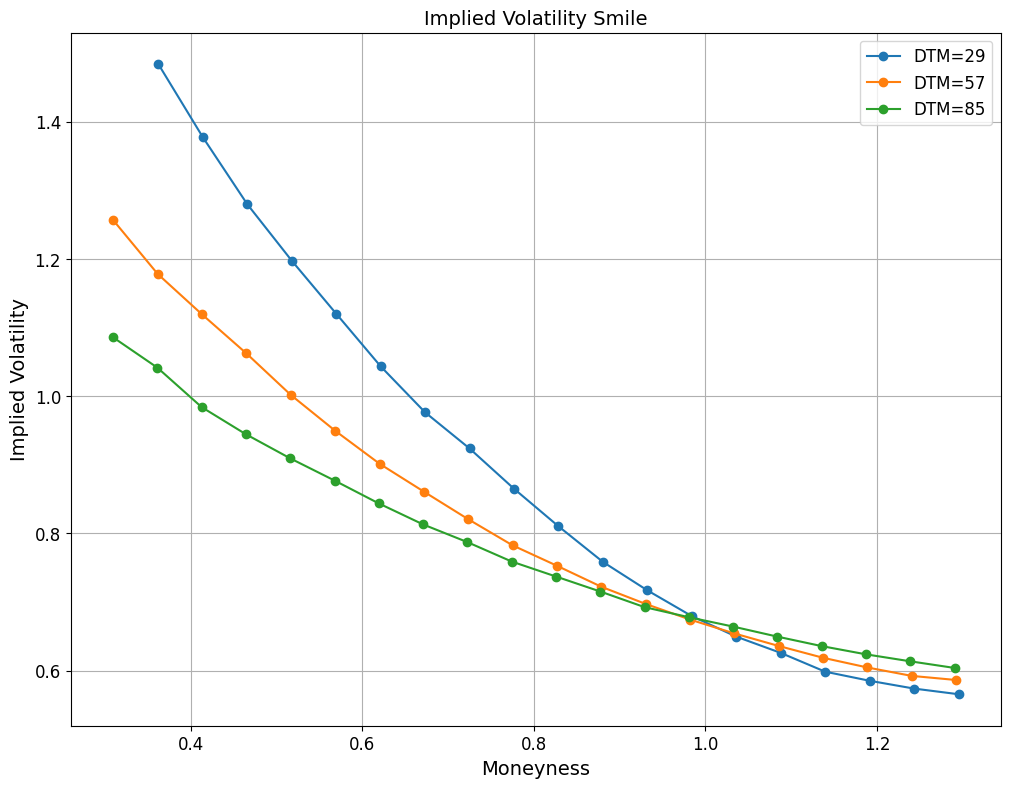

In [6]:
sample = pd.DataFrame(surface)[surface["DTM"] <= 90][surface["MNY"] <= 1.3]
sample.set_index('index', inplace=True, drop=True)
summarize_surface(sample)

En observant le graphique ci-dessus, nous pouvons voir que la pente de la volatilité implicite devient plus importante plus l'échéance est proche. En effet, concernant l'aile gauche, nous pouvons voir que la volatilité implicite des options avec un faible moneyness est beaucoup plus importante que sur le reste de la courbe, faute à l'incertitude importante des prochains mois. Le fait que les options à échéance plus courte soient beaucoup plus sollicité montre bien la volonté de se couvrir face à des pertes très importantes à très court terme et représente bien la situation de crise économique. 
De l'autre coté de l'axe, nous pouvons voir que la volatilité implicite réduit avec la proximité de l'échéance. En effet, peu de personnes suspectent la hausse des prix dans un avenir proche, ce qui entraine une volatilité implicite très réduite à court terme. 

Concernant l'évolution de ses courbes dans le temps, nous pouvons voir que plus la maturité augmente, plus la courbe de volatilité implicite tend à s'applatir. Cela est explicable car à plus long terme, la volatilité implicite au prix de l'option tend à être plus uniforme et moins dépendant de la moneyness actuelle. En effet, plus la maturité augmente, moins le moneyness actuel de l'option est important dans son attractivité pour les investisseurs, ce qui implique donc que la demande et l'offre se stabilisent sur le spectre de la moneyness. Cette stabilisation se justifie par la réduction de l'incertitude court terme et la baisse prévue de l'intensité de la crise. 

## Question 3

Sous-échantillonez `sample` en un DataFrame `otm_puts` qui contiendra les 9 puts de 3 mois ou moins de maturité et de strike `[75, 85, 95]`. Ce sont des puts americans; considérons pour l'instant les puts européens de même charactéristiques. Utilisez la formule de BMS pour évaluer ces puts en posant, en particulier:
```
   S_exdiv = np.exp(-rf*T)*put.implied_forward_price
   y = 0 # The dividend yield
```

En vous inspirant du notebook `ch04_discrete_time`, tracer dans une figure 3x3 (e.g. `plt.subplots(3, 3, figsize=(20, 20))`) les graphes de convergences (avec l'ajustement de Broadie et Detemple) pour les 9 jeux de paramètres. Assurez-vous de bien identifier chacune des sous-figures à l'aide d'un titre décrivant l'option (`DTM,K`). Utilisez des marges de $\pm 50$bps. Décrivez la figure que vous obtenez.

À partir de combien de pas de temps (que nous dénoterons `N_star`) le prix dans l'arbre de toutes les options demeurrent-ils à l'intérieur de la tolérance de $\pm 50$bps?

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\337598666.py:67: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  puts["N_star"][i * 3 + j] = graph_maker(axes[i, j], puts, i * 3 + j, 200, 'euro')
C:\Users\Benjamin\AppData\Local\Temp\ipykern

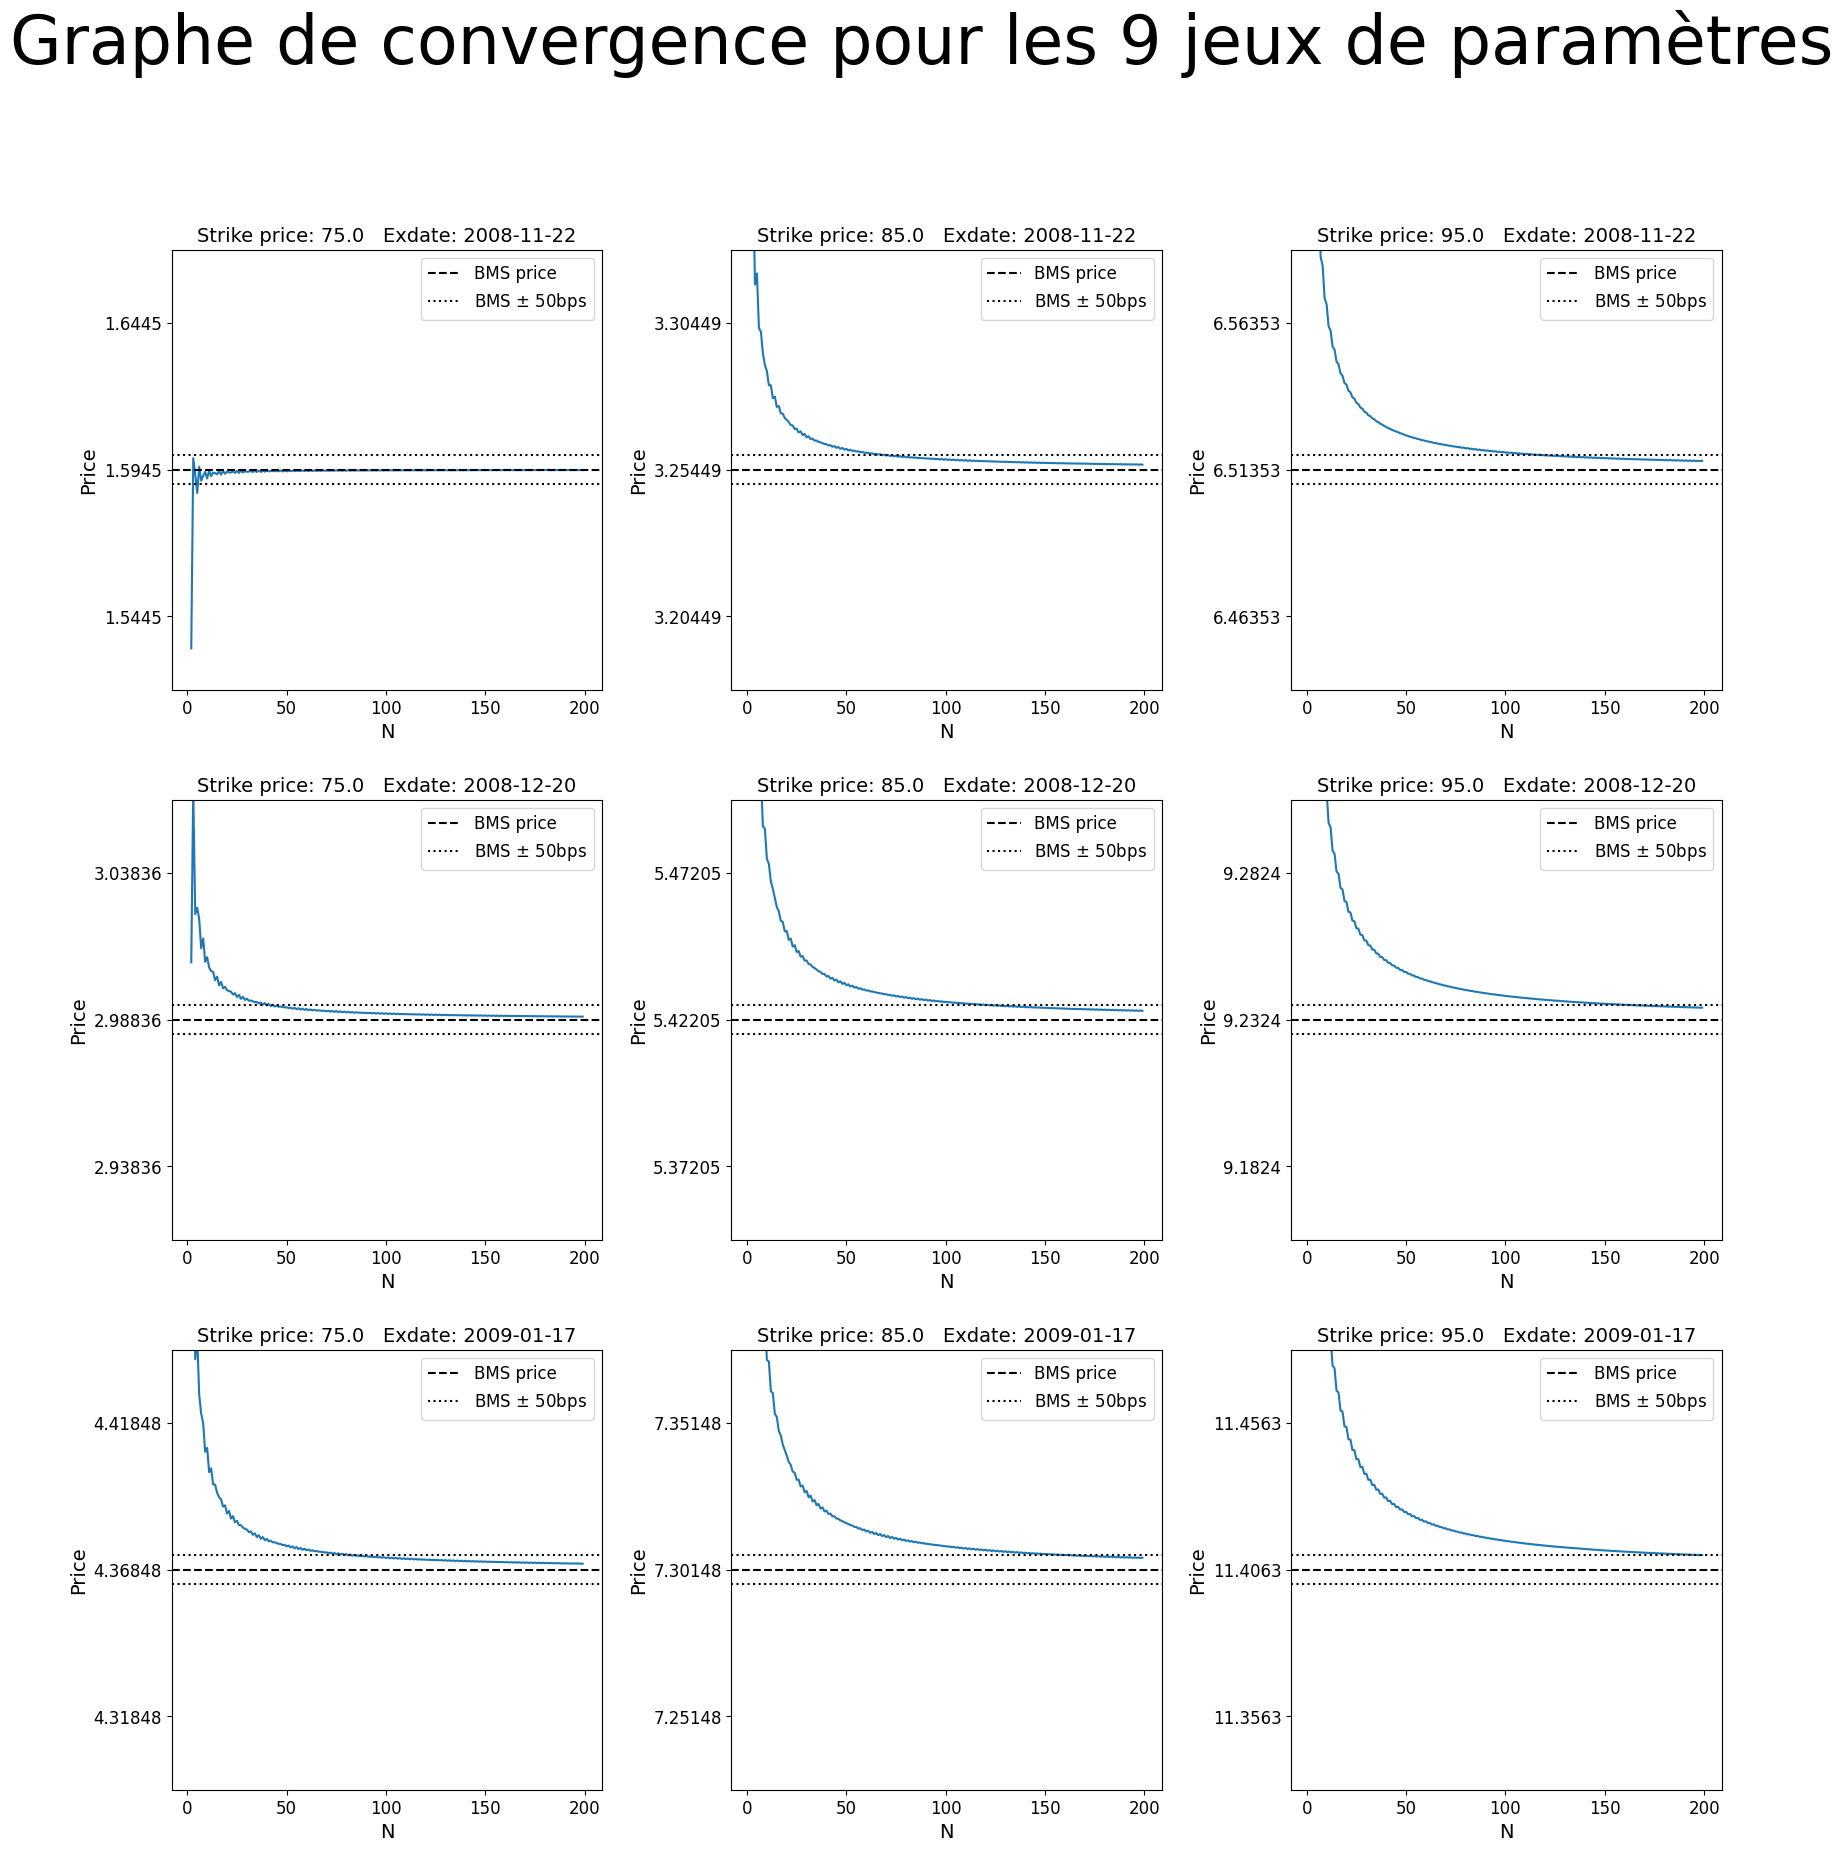

In [7]:
def f_otm_puts_tranform(x): 
    """
    Fonction qui prend en input notre dataframe et output un dataframe réduit selon nos contraintes sur la valeur du strike, la maturité et le type de l'option
    """
    x = x[x["strike"].isin([95, 85, 75])]
    x = x[x["is_call"]== False]
    x = x[x["DTM"] <= 90]
    return x

def plot_convergence(ax, conv_price , n_steps, prices, bps=50):
    
    """
    Fonction qui formatte chacun des sous graphiques dans notre grille de graphiques
    """
    
    ax.plot(n_steps, prices)
    ax.axhline(conv_price, linestyle='--', color='k', label='BMS price')
    ax.axhline(conv_price-bps/1e4, linestyle=':', color='k', label='BMS $\pm$ %dbps'%bps)
    ax.axhline(conv_price+bps/1e4, linestyle=':', color='k')
    ax.set_xlabel('N')
    ax.set_ylabel('Price')
    ax.legend()
    off = 10*bps/1e4
    ax.set_yticks([conv_price-off,conv_price,conv_price+off])
    ax.set_ylim([conv_price-1.5*off,conv_price+1.5*off])
    
def graph_maker(ax, otm_puts, k, steps = 200 , type = 'euro'):   
    
    """
    Cette fonction calcul le prix des options pour un sous-jascent ainsi et gere l'évaluation du nombre de steps necessaire pour la convergence d'un arbre binomiale vers le modele Black-Merton-Scholes
    """
    
    bps = 50
    n_steps = np.arange(2,steps)
    bin_price = np.nan*n_steps
    otm_puts = otm_puts.iloc[k,:]

    for i in n_steps:
        _,euro,am,_,_ = option_price(otm_puts["stock_price"], otm_puts["strike"],otm_puts["risk_free"],y ,otm_puts["DTM"]/days_per_year,otm_puts["implied_vol_bms"], i, otm_puts["is_call"], bms_adj=True)
        
        if type == 'euro':
            bin_price[i-2] = euro[0,0]
        else:
            bin_price[i-2] = am[0,0]
   
    plot_convergence(ax, otm_puts["The_EU_Price"],n_steps, bin_price, bps)

    N_star = 50
    good_price = np.where((bin_price >= otm_puts["The_EU_Price"] + bps/1e4)|(bin_price <= otm_puts["The_EU_Price"] - bps/1e4))
    
    if len(good_price[0]) > 0:
        N_star = good_price[-1][-1]
    
    return N_star

def subplot_maker(puts, index_names):

    """
    Formatte la grille de graphique et appelle la fonction graph_maker pour chaque sous graphique
    """

    fig, axes = plt.subplots(3, 3, figsize=(20,20))
    puts["N_star"] = 0
    
    for i in range(3):
        for j in range(3):
            puts["N_star"][i * 3 + j] = graph_maker(axes[i, j], puts, i * 3 + j, 200, 'euro')
            axes[i, j].set_title(index_names[i * 3 + j])
            axes[i, j].legend()
    
    fig.suptitle('Graphe de convergence pour les 9 jeux de paramètres',fontsize=48, y=1)
    fig.subplots_adjust(wspace=0.3, hspace=0.25)

    plt.show()
    return puts


days_per_year = 365
y = 0

# otm_puts formatage et création de S_exdiv et Th_EU_Price
otm_puts = f_otm_puts_tranform(sample)
otm_puts["S_exdiv"] = np.exp(-otm_puts['risk_free']*otm_puts['DTM']/days_per_year)*otm_puts['implied_forward_price']
otm_puts["The_EU_Price"] = bms.option_price(otm_puts["stock_price"],otm_puts["strike"],otm_puts["risk_free"],y,otm_puts["DTM"]/days_per_year,otm_puts["implied_vol_bms"],otm_puts["is_call"])

n_steps = np.arange(2,200)
bin_price = np.nan*n_steps


otm_puts_subset = otm_puts[["strike", "exdate"]]
graph_names = []
for index, row in otm_puts_subset.iterrows():
    strike_value = row['strike']
    exdate_value = row['exdate']
    graph_names.append(f"Strike price: {strike_value}   Exdate: {exdate_value}")

N_star_list = subplot_maker(otm_puts, graph_names)


In [8]:
otm_puts

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,best_bid,best_offer,volume,...,risk_free,stock_price,implied_forward_price,implied_vol_bms,implied_vol_bid,implied_vol_ask,MNY,S_exdiv,The_EU_Price,N_star
index,,,,,,,,,,,,,,,,,,,,,
2008-10-24,101594.0,2008-10-24,QAA.WO,0,2008-11-22,2008-10-24,P,1.55,1.66,5150.0,...,0.030536,96.38,96.528704,0.865054,0.855075,0.874913,0.776971,96.294797,1.594495,3
2008-10-24,101594.0,2008-10-24,QAA.WQ,0,2008-11-22,2008-10-24,P,3.20,3.35,7929.0,...,0.030536,96.38,96.528704,0.758417,0.749539,0.767260,0.880567,96.294797,3.254488,69
2008-10-24,101594.0,2008-10-24,QAA.WS,0,2008-11-22,2008-10-24,P,6.45,6.65,14232.0,...,0.030536,96.38,96.528704,0.679384,0.670000,0.688769,0.984163,96.294797,6.513532,117
2008-10-24,101594.0,2008-10-24,QAA.XO,0,2008-12-20,2008-10-24,P,2.91,3.10,1053.0,...,0.030175,96.38,96.733148,0.782558,0.772423,0.792608,0.775329,96.278384,2.988361,41
2008-10-24,101594.0,2008-10-24,QAA.XQ,0,2008-12-20,2008-10-24,P,5.35,5.55,1156.0,...,0.030175,96.38,96.733148,0.722189,0.714314,0.730049,0.878706,96.278384,5.422051,121
2008-10-24,101594.0,2008-10-24,QAA.XS,0,2008-12-20,2008-10-24,P,9.15,9.40,1182.0,...,0.030175,96.38,96.733148,0.674374,0.665971,0.682778,0.982083,96.278384,9.232368,161
2008-10-24,101594.0,2008-10-24,QAA.MO,0,2009-01-17,2008-10-24,P,4.25,4.55,1290.0,...,0.028906,96.38,96.862495,0.758939,0.746952,0.770841,0.774293,96.212648,4.368477,82
2008-10-24,101594.0,2008-10-24,QAA.MQ,0,2009-01-17,2008-10-24,P,7.20,7.50,960.0,...,0.028906,96.38,96.862495,0.715247,0.705814,0.724666,0.877533,96.212648,7.301480,159
2008-10-24,101594.0,2008-10-24,QAA.MS,0,2009-01-17,2008-10-24,P,11.25,11.70,849.0,...,0.028906,96.38,96.862495,0.677777,0.665327,0.690233,0.980772,96.212648,11.406256,195



En analysant le graphique plus haut et le nombre de steps nécessaire à la convergeance (dans l'intervalle de 50 bps) de nos différentes options, nous pouvons déduire que ce nombre augmente si la maturité augmente et si le strike price se rapproche du prix actuel. Pour comprendre cela, nous pouvons nous réferer à la méthode d'estimation qui utilise un arbre binomial de N steps. Ainsi, pour la maturité, plus elle est importante, plus un nombre de périodes important est nécessaire afin d'obtenir une meilleure idée des directions que peut prendre le sous-jacent lors de la période. Concernant le strike price, nous pouvons imaginer que plus la certitude d'être ITM ou OTM est importante, moins nous avons besoin de nous assurer d'avoir un nombre important de scénarios. En effet, l'arbre binomial est intéressant quand l'on se trouve dans des régions proches de l'ATM, car la valeur entre nos branches est plus changeante, contrairement aux autres régions, ou l'on actualise un prix moyen ou des 0 en boucle. 

Ainsi nous pouvons conclure à la pertinence des différents N_stars trouvés : 

Maturité 1 mois :
Strike de 1 mois : 3
Strike de 2 mois : 69
Strike de 3 mois : 117

Maturité 2 mois :
Strike de 1 mois : 41
Strike de 2 mois : 121
Strike de 3 mois : 161

Maturité 3 mois :
Strike de 1 mois : 82
Strike de 2 mois : 159
Strike de 3 mois : 195

## Question 4

Tabulez les valeur des 9 puts en question de la façons suivante:
```
  | DTM | K | BMS | CRR Euro | CRR Amer  | Marché |
```
où les valeurs CRR auront été obtenues à `N_star`. Vos résultats semblent probablement paradoxaux. Qu'est-ce qui explique l'incohérence des résultats? Comment pourrions-nous corriger la situation?

In [9]:
#['DTM', 'K', 'e', 'CRR_Euro', 'CRR_Amer', 'option_price']
colonnes_to_keep = ['DTM', 'strike', 'The_EU_Price', 'CRR_Euro', 'CRR_Amer','option_price']
otm_puts["CRR_Euro"] = 0
otm_puts["CRR_Amer"] = 0

# Estimation des prix des options américaines et européennes avec la méthode CRR
for i in range(len(otm_puts)):
    df_puts_temp = otm_puts.iloc[i,:]
    _,euro,am,_,_ = option_price(df_puts_temp["stock_price"], df_puts_temp["strike"],df_puts_temp["risk_free"],y ,df_puts_temp["DTM"]/days_per_year,df_puts_temp["implied_vol_bms"], 1000, df_puts_temp["is_call"], bms_adj=True)
    otm_puts["CRR_Euro"][i] = euro[0,0]
    otm_puts["CRR_Amer"][i] = am[0,0]

      
df_puts = pd.DataFrame(otm_puts)
df_puts = df_puts.loc[:, colonnes_to_keep]
df_puts.rename(columns={"option_price": "Marché", "The_EU_Price":"BMS"}, inplace=True)
        
print(df_puts)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\4204895621.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  otm_puts["CRR_Euro"][i] = euro[0,0]
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\4204895621.py:10: SettingWithCopyWarn

            DTM  strike        BMS   CRR_Euro   CRR_Amer  Marché
index                                                           
2008-10-24   29    75.0   1.594495   1.594474   1.595953   1.605
2008-10-24   29    85.0   3.254488   3.254836   3.258962   3.275
2008-10-24   29    95.0   6.513532   6.514130   6.525655   6.550
2008-10-24   57    75.0   2.988361   2.988575   2.993802   3.005
2008-10-24   57    85.0   5.422051   5.422674   5.434727   5.450
2008-10-24   57    95.0   9.232368   9.233196   9.259353   9.275
2008-10-24   85    75.0   4.368477   4.368896   4.379377   4.400
2008-10-24   85    85.0   7.301480   7.302285   7.323709   7.350
2008-10-24   85    95.0  11.406256  11.407242  11.448178  11.475


In [10]:
df_puts[[ "strike", "DTM","BMS","CRR_Amer","CRR_Euro","Marché"]]

,strike,DTM,BMS,CRR_Amer,CRR_Euro,Marché
index,,,,,,
2008-10-24,75.0,29,1.594495,1.595953,1.594474,1.605
2008-10-24,85.0,29,3.254488,3.258962,3.254836,3.275
2008-10-24,95.0,29,6.513532,6.525655,6.514130,6.550
2008-10-24,75.0,57,2.988361,2.993802,2.988575,3.005
2008-10-24,85.0,57,5.422051,5.434727,5.422674,5.450
2008-10-24,95.0,57,9.232368,9.259353,9.233196,9.275
2008-10-24,75.0,85,4.368477,4.379377,4.368896,4.400
2008-10-24,85.0,85,7.301480,7.323709,7.302285,7.350
2008-10-24,95.0,85,11.406256,11.448178,11.407242,11.475


Nous pouvons observer dans notre tableau que le prix estimé par le CRR pour les options européennes est légèrement différent du prix théorique, car nous prenons la borne atteinte en N_star. Concernant la différence entre le prix américain et européen, nous pouvons voir comme attendu que le prix américain est supérieur à celui européen, bien que le prix du droit d'exercice prématuré nous semble très faible en vue de la flexibilité offerte par ce droit dans ce contexte d'incertitude économique. En comparant maintenant notre prix américain avec le prix du marché, nous nous rendons compte que nous avons sous-estimé de manière systématique le prix actuel du marché. Autrement dit, le prix qui se transige sur les marchés est surévalué sous l'hypothèse de BMS. Cette surévaluation vient de l'asymétrie de la distribution des rendements récents, qui ne suivent pas une loi normale (dans le contexte de la crise de 2008). Ainsi, n'ayant pas fait une correction pour la distribution des rendements du sous-jacent, nous sous-estimons le downside risque. Comme nous évaluons des puts, ce risque provoque une sous-estimation du prix de nos options. 



## Question 5

Négligeons maintenant cette incohérence et remplaçons la colonne `Marché` par une colonne de prix obtenus via l'approche de Carr, Jarrow et Myneni (1993):
```
  | DTM | K | BMS | CRR Euro | CRR Amer  | CJM |
```
Comment les colonnes `CRR Amer` et `CJM` se compare-t-elle? Répétez 100 fois le calculs de chacune de ce deux colonnes en prennant soin d'encadrer le tout d'appel à `tic()` et `toc()`. Comment le temps de calcul des deux méthodes se compare-t-il?

In [11]:
colonnes_to_keep = ['DTM', 'strike', 'BMS', 'CRR_Euro', 'CRR_Amer']
df_puts_cjm = pd.DataFrame(df_puts)
df_puts_cjm = df_puts_cjm.loc[:, colonnes_to_keep]


In [12]:
# Paramètres connus
K = 100  # Prix d'exercice de l'option, exemple générique
r = 0.05  # Taux d'intérêt sans risque
sigma = 0.3  # Volatilité
T = 1  # Maturité
# Temps actuel t, pour le calcul de tau
t = 0  # on commence à t=0 pour simplifier, mais cela peut être n'importe quelle valeur entre 0 et T
tau = T - t

# Utilisation de fsolve pour trouver la valeur de m qui résout l'équation
initial_guess = 2 #np.sqrt(2*r/sigma**2)  # Une estimation initiale de m

# Fonction erf, liée à la fonction de distribution normale cumulée
def erf(x):
    return 2 * norm.cdf(x * np.sqrt(2)) - 1

# Fonction pour le calcul de beta(tau)
def beta(T, t, sigma, r, m):
    tau = T - t
    return (3 * sigma / 4) - (r / (2 * sigma)) + (m / (2 * np.sqrt(tau)))

# Fonction à résoudre pour trouver m (la fonction de laquelle nous voulons trouver la racine)
def equation_to_solve(m, T, t, sigma, r):
    tau = T - t
    left_side = sigma * np.exp(- (r + (sigma ** 2) / 2) * tau - sigma * np.sqrt(tau) * m) * norm.cdf(-m)
    right_side = (r * erf(np.sqrt((0.5 * beta(T, t, sigma, r, m) ** 2 + r) * tau))) / np.sqrt(beta(T, t, sigma, r, m) ** 2 + 2 * r)
    return left_side - right_side

def cjm_solver(T, t, initial_guess, r, sigma, K):
    tau = T - t
    # trouve la racine de l'équation
    m_solution = fsolve(equation_to_solve, initial_guess, args=(T,t,sigma,r,), maxfev = 600)

    # Calcul de B(t) une fois que m est trouvé
    B_t = float(K * np.exp(- (r + (sigma ** 2) / 2) * tau - sigma * np.sqrt(tau) * m_solution))
    return B_t

# Fonction qui estime de la valeur de la composante -d_2 dans la valeur du premium de l'option Americaine selon CJM
def m_d2(S, t, r, sigma, B_t):
    return (np.log(B_t/S) - (r - sigma**2/2)*t) / (sigma * np.sqrt(t))

# Fonction qui evalue la valeur du premium de l'option Americaine selon CJM
def integrand(t, S0, r, initial_guess, sigma,K):
    
    d2_val = m_d2(S0, t, r, sigma, cjm_solver(T,t, initial_guess, r, sigma,K))
    return np.exp(-r*t) * norm.cdf(d2_val)


In [13]:
# Benchmarking de la methode CJM avec les resultats du professeur. Voir notes de cours
"""
S_0 = 100
r = 0.05
initial_guess = 2
sigma = 0.3
K = 100
v, _ = quad(integrand, 0, T, args=(S_0, r, initial_guess, sigma, K))
p_eu = bms.option_price(S_0, K, r, 0, T, sigma, is_call= False)
print(v * r * K)
print(round(p_eu + v * r * K,4))
"""

'\nS_0 = 100\nr = 0.05\ninitial_guess = 2\nsigma = 0.3\nK = 100\nv, _ = quad(integrand, 0, T, args=(S_0, r, initial_guess, sigma, K))\np_eu = bms.option_price(S_0, K, r, 0, T, sigma, is_call= False)\nprint(v * r * K)\nprint(round(p_eu + v * r * K,4))\n'

In [14]:
otm_puts["CJM"] = 0

CRR_list = []
toolkit.tic()

# Estimate CJM model and record the time 
for j in range(100):
    for i in range(len(otm_puts["CJM"])):
        v, _ = quad(integrand, 0, T, args=(otm_puts["stock_price"][i], otm_puts["risk_free"][i], initial_guess, otm_puts["implied_vol_bms"][i], otm_puts["strike"][i]))
        otm_puts["CJM"][i] =  otm_puts["The_EU_Price"][i] + v * otm_puts["risk_free"][i] * otm_puts["strike"][i]

toolkit.toc()

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\1440773570.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v, _ = quad(integrand, 0, T, args=(otm_puts["stock_price"][i], otm_puts["risk_free"][i], initial_guess, otm_puts["implied_vol_bms"][i], otm_puts["strike"][i]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\2607615468.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B_t = float(K * np.exp(- (r + (sigma ** 2) / 2) * tau - sigma * np.sqrt(tau) * m_solution))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\1440773570.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

Elapsed time: 403.770082 seconds.


403.77008170000045

In [15]:
otm_puts["diff"] = 0
otm_puts["diff"] = (otm_puts["CJM"] - otm_puts["CRR_Amer"])/otm_puts["CRR_Amer"]
puts_q5 = otm_puts[["strike","DTM","The_EU_Price","CRR_Euro",'CRR_Amer',"CJM"]].rename(columns={"The_EU_Price":"BMS"})

In [16]:
print(puts_q5)

            strike  DTM        BMS   CRR_Euro   CRR_Amer        CJM
index                                                              
2008-10-24    75.0   29   1.594495   1.594474   1.595953   1.756800
2008-10-24    85.0   29   3.254488   3.254836   3.258962   3.467511
2008-10-24    95.0   29   6.513532   6.514130   6.525655   6.801953
2008-10-24    75.0   57   2.988361   2.988575   2.993802   3.134448
2008-10-24    85.0   57   5.422051   5.422674   5.434727   5.626071
2008-10-24    95.0   57   9.232368   9.233196   9.259353   9.516134
2008-10-24    75.0   85   4.368477   4.368896   4.379377   4.503465
2008-10-24    85.0   85   7.301480   7.302285   7.323709   7.494251
2008-10-24    95.0   85  11.406256  11.407242  11.448178  11.676208


In [17]:
CRR_list = []

toolkit.tic()
# Estimate CRR model and record the time
for i in range(100):
    for j in range(len(otm_puts)):
        df_puts_temp = otm_puts.iloc[j,:]
        _,_,am,_,_ = option_price(df_puts_temp["stock_price"], df_puts_temp["strike"], df_puts_temp["risk_free"], y, df_puts_temp["DTM"]/days_per_year,df_puts_temp["implied_vol_bms"],df_puts_temp["N_star"], df_puts_temp["is_call"], bms_adj=True)
        otm_puts["CRR_Amer"][j] = am[0,0]
toolkit.toc()

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\355890285.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  otm_puts["CRR_Amer"][j] = am[0,0]
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\355890285.py:9: SettingWithCopyWarning: 


Elapsed time: 8.070757 seconds.


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\355890285.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otm_puts["CRR_Amer"][j] = am[0,0]
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\355890285.py:9: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  otm_puts["CRR_Amer"][j] = am[0,0]
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_9612\355890285.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otm_puts["CRR_Amer"][j]

8.070757300010882

Nous pouvons remarquer que le temps de calcul de la méthode CJM (4 secondes/loop) est beaucoup plus long que celui de la méthode CRR (0.08 seconde/loop). La raison pour cela est le relativement bas nombre de "steps" avec lequel on évalue les prix des options avec la méthode CRR. En effet, de part nature, la complexité computationnelle de la méthode CRR augmente exponentiellement au fur et à mesure que le nombre de steps augmente. Si nous nous trouvions à resserré l'interval de BPS ou a apporté quelconque changement dans le problème qui aurait comme conséquence d'augmenter le nombre de steps, alors CRR dépasserait rapidement CJM en temps de calcul puisque CJM se rapproche davantage d'une solution analytique.
 